Esteban Castañeda Blanco C01795

Israel López Vallecillo C04396

Daniel Lizano Morales C04285

In [125]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [126]:
data_transforms = {
    'all': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}


In [158]:
unlabeled_set_size = 0.8
labeled_train_absolute_set_size = 0.1
labeled_test_absolute_set_size = round(1 - (labeled_train_absolute_set_size + unlabeled_set_size), 2)

labeled_train_relative_set_size = round((labeled_train_absolute_set_size / (1 - unlabeled_set_size)), 2)
labeled_test_relative_set_size = 1 - labeled_train_relative_set_size

In [160]:
base_dir = os.path.join('Plant_leave_diseases_dataset', 'original')
os.makedirs('best_models', exist_ok=True)
model_save_path = \
    os.path.join('best_models', f'h1_{int(unlabeled_set_size*100)}-{int(labeled_train_absolute_set_size*100)}-{int(labeled_test_absolute_set_size*100)}_classifierA.pth')

In [128]:
full_dataset = datasets.ImageFolder(base_dir, transform=data_transforms['all'])

In [129]:
indices = list(range(len(full_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]

In [130]:
#Obtenemos el 20% de los datos 
train_val_indices, _ = train_test_split(indices, test_size=unlabeled_set_size, stratify=labels, random_state=42)

#Obtenemos las etiquetas de los datos de entrenamiento
train_val_labels = [labels[i] for i in train_val_indices]

#dividir el 20% en 10% de entrenamiento y 10% de validación
train_indices, val_indices = train_test_split(train_val_indices, test_size=labeled_test_relative_set_size, stratify=train_val_labels, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

In [131]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Número de imágenes en el conjunto de entrenamiento: {len(train_loader.dataset)}")
print(f"Número de imágenes en el conjunto de validación: {len(val_loader.dataset)}")

Número de imágenes en el conjunto de entrenamiento: 6148
Número de imágenes en el conjunto de validación: 6149


In [139]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b2()

# Modify the first convolutional layer to accept a different number of input channels (e.g., 1 instead of 3)
new_in_channels = 1  # Change this to the desired number of input channels
original_conv1 = model.features[0][0]

new_conv1 = nn.Conv2d(
    in_channels=new_in_channels,
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding,
    bias=original_conv1.bias
)

# Initialize the weights of the new conv layer
with torch.no_grad():
    if new_in_channels == 1:
        # Average the weights of the original conv layer across the input channels
        new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
    else:
        # Initialize weights by repeating the mean weights or use a different strategy
        new_conv1.weight[:, :3] = original_conv1.weight
        if new_in_channels > 3:
            for i in range(3, new_in_channels):
                new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)

# Replace the first convolutional layer in the model
model.features[0][0] = new_conv1

# Print the modified first convolutional layer
print("Modified first conv layer:", model.features[0][0])
# model._conv_stem = nn.Conv2d(1, model._conv_stem.out_channels, kernel_size=model._conv_stem.kernel_size, stride=model._conv_stem.stride, padding=model._conv_stem.padding, bias=False)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Modified first conv layer: Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


In [133]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return figure

In [134]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_path)
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
    
    return model

In [135]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    cm_figure = plot_confusion_matrix(cm, class_names=dataloader.dataset.dataset.classes)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=dataloader.dataset.dataset.classes, yticklabels=dataloader.dataset.dataset.classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix - Evaluation')
    plt.show()
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(all_labels, all_preds, target_names=dataloader.dataset.dataset.classes))
    
    return accuracy

In [140]:
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=20, patience=3)


100%|██████████| 193/193 [01:28<00:00,  2.19it/s]


Epoch 1/20
Train Loss: 3.3029 Acc: 0.1845
Val Loss: 2.6981 Acc: 0.2674


100%|██████████| 193/193 [01:22<00:00,  2.33it/s]


Epoch 2/20
Train Loss: 2.4347 Acc: 0.3162
Val Loss: 2.2371 Acc: 0.3557


100%|██████████| 193/193 [01:30<00:00,  2.14it/s]


Epoch 3/20
Train Loss: 1.9932 Acc: 0.4214
Val Loss: 1.6600 Acc: 0.5074


100%|██████████| 193/193 [01:39<00:00,  1.93it/s]


Epoch 4/20
Train Loss: 1.6787 Acc: 0.5011
Val Loss: 1.6589 Acc: 0.5191


100%|██████████| 193/193 [01:42<00:00,  1.89it/s]


Epoch 5/20
Train Loss: 1.3920 Acc: 0.5766
Val Loss: 1.3433 Acc: 0.5827


100%|██████████| 193/193 [01:16<00:00,  2.51it/s]


Epoch 6/20
Train Loss: 1.1423 Acc: 0.6459
Val Loss: 1.1451 Acc: 0.6634


100%|██████████| 193/193 [01:19<00:00,  2.44it/s]


Epoch 7/20
Train Loss: 1.0171 Acc: 0.6848
Val Loss: 1.0997 Acc: 0.6759


100%|██████████| 193/193 [01:19<00:00,  2.44it/s]


Epoch 8/20
Train Loss: 0.8913 Acc: 0.7209
Val Loss: 0.8975 Acc: 0.7248


100%|██████████| 193/193 [01:21<00:00,  2.38it/s]


Epoch 9/20
Train Loss: 0.7770 Acc: 0.7526
Val Loss: 0.8501 Acc: 0.7388


100%|██████████| 193/193 [01:25<00:00,  2.27it/s]


Epoch 10/20
Train Loss: 0.7071 Acc: 0.7744
Val Loss: 0.8250 Acc: 0.7535


100%|██████████| 193/193 [01:16<00:00,  2.53it/s]


Epoch 11/20
Train Loss: 0.5787 Acc: 0.8121
Val Loss: 0.8257 Acc: 0.7580


100%|██████████| 193/193 [01:29<00:00,  2.15it/s]


Epoch 12/20
Train Loss: 0.5522 Acc: 0.8238
Val Loss: 0.7109 Acc: 0.7848


100%|██████████| 193/193 [01:36<00:00,  2.01it/s]


Epoch 13/20
Train Loss: 0.4892 Acc: 0.8401
Val Loss: 0.6683 Acc: 0.7969


100%|██████████| 193/193 [01:34<00:00,  2.05it/s]


Epoch 14/20
Train Loss: 0.4251 Acc: 0.8614
Val Loss: 0.9283 Acc: 0.7486


100%|██████████| 193/193 [01:16<00:00,  2.54it/s]


Epoch 15/20
Train Loss: 0.3814 Acc: 0.8723
Val Loss: 0.6942 Acc: 0.7935


100%|██████████| 193/193 [01:23<00:00,  2.31it/s]


Epoch 16/20
Train Loss: 0.3494 Acc: 0.8884
Val Loss: 0.6200 Acc: 0.8140


100%|██████████| 193/193 [01:17<00:00,  2.50it/s]


Epoch 17/20
Train Loss: 0.3171 Acc: 0.8962
Val Loss: 1.1079 Acc: 0.7697


100%|██████████| 193/193 [01:17<00:00,  2.49it/s]


Epoch 18/20
Train Loss: 0.3379 Acc: 0.8874
Val Loss: 0.6218 Acc: 0.8244


100%|██████████| 193/193 [01:38<00:00,  1.96it/s]


Epoch 19/20
Train Loss: 0.3211 Acc: 0.8939
Val Loss: 0.7235 Acc: 0.7953
Early stopping triggered!


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000270E39DDBC0>
Traceback (most recent call last):
  File "c:\Users\ISRAEL\Documents\Estudios\UCR\Computacion\MachineLearning\proyecto3\plant_disease_classification\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\ISRAEL\Documents\Estudios\UCR\Computacion\MachineLearning\proyecto3\plant_disease_classification\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


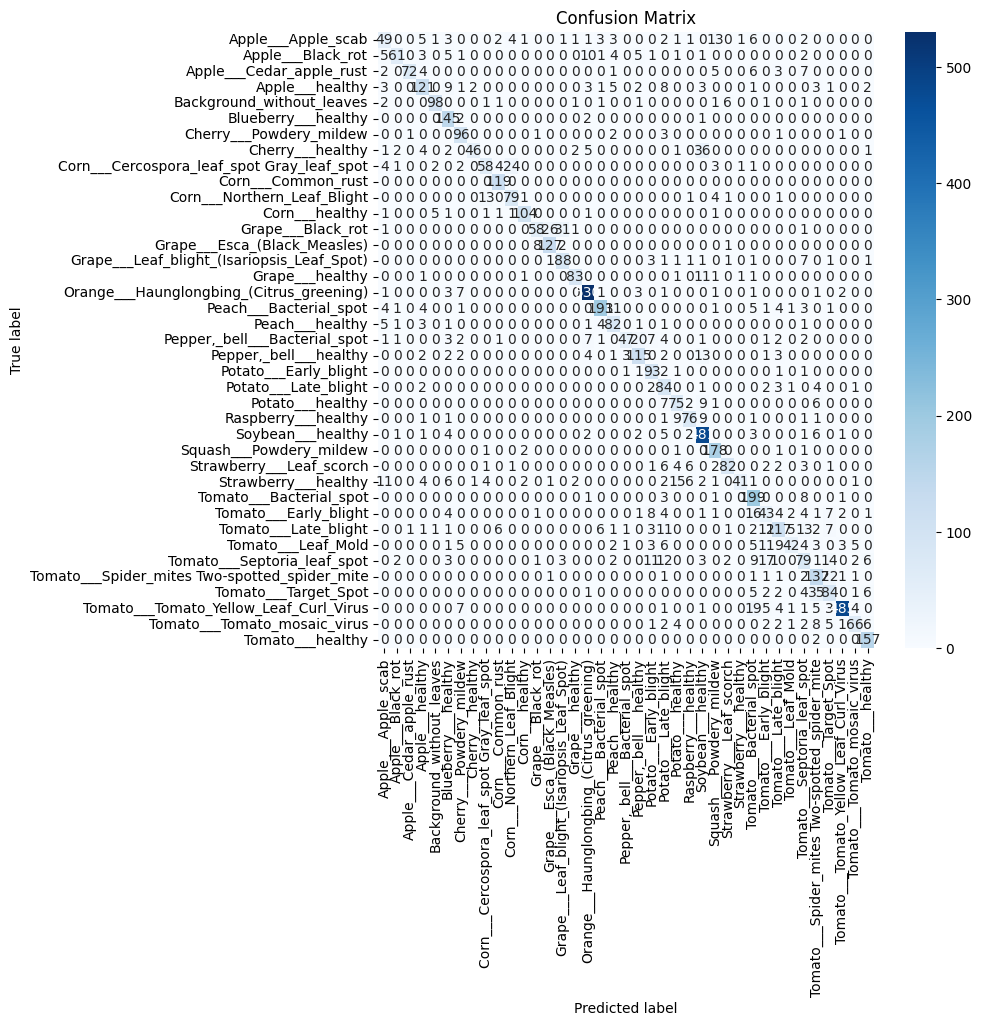

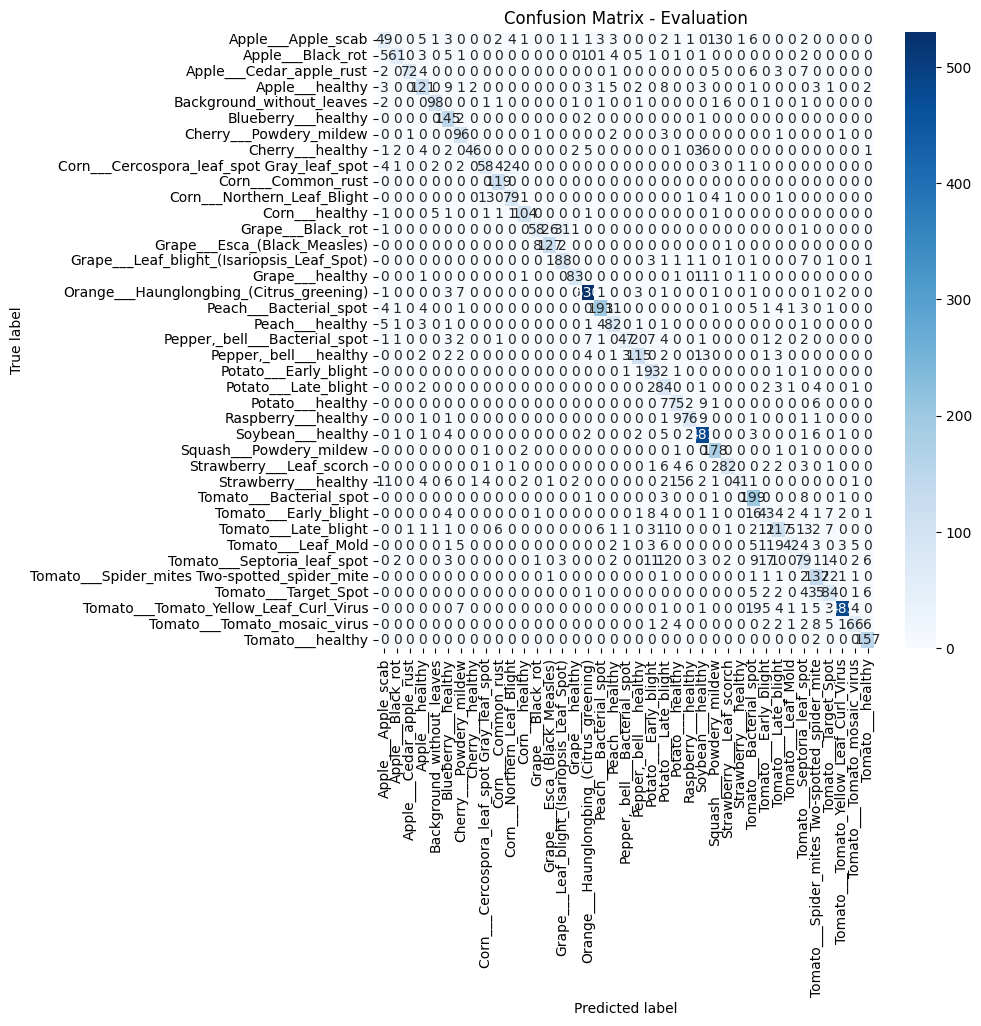

Accuracy: 0.7953
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.54      0.49      0.52       100
                            Apple___Black_rot       0.87      0.61      0.72       100
                     Apple___Cedar_apple_rust       0.97      0.72      0.83       100
                              Apple___healthy       0.78      0.73      0.75       165
                    Background_without_leaves       0.92      0.86      0.89       114
                          Blueberry___healthy       0.75      0.97      0.84       150
                      Cherry___Powdery_mildew       0.76      0.91      0.83       105
                             Cherry___healthy       0.94      0.46      0.62       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.73      0.58      0.65       100
                           Corn___Common_rust       0.89      1.00      0.94       119
                  Corn___

0.7952512603675395

In [163]:
evaluate_model(trained_model, val_loader, device)